# Example - Reproject

In [1]:
import rioxarray # for the extension to load
import xarray
import rasterio

%matplotlib inline

## Load in xarray dataset

In [2]:
xds = xarray.open_dataset("../../test/test_data/input/PLANET_SCOPE_3D.nc")

In [3]:
xds

<xarray.Dataset>
Dimensions:      (time: 2, x: 10, y: 10)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float64 4.663e+05 4.663e+05 ... 4.663e+05 4.663e+05
  * time         (time) datetime64[ns] 2016-12-19T10:27:29.687763 2016-12-29T...
  * y            (y) float64 8.085e+06 8.085e+06 ... 8.085e+06 8.085e+06
Data variables:
    blue         (time, y, x) float64 ...
    green        (time, y, x) float64 ...

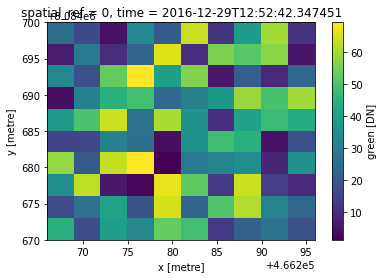

In [4]:
xds.green.where(xds.green!=xds.green.rio.nodata).isel(time=1).plot()

## Reproject

API Reference:

- DataArray: [rio.reproject()](../rioxarray.rst#rioxarray.raster_array.RasterArray.reproject)
- Dataset: [rio.reproject()](../rioxarray.rst#rioxarray.raster_dataset.RasterDataset.reproject)

In [5]:
xds_lonlat = xds.rio.reproject("EPSG:4326")

In [6]:
xds_lonlat

<xarray.Dataset>
Dimensions:      (time: 2, x: 10, y: 10)
Coordinates:
  * x            (x) float64 -51.32 -51.32 -51.32 ... -51.32 -51.32 -51.32
  * y            (y) float64 -17.32 -17.32 -17.32 ... -17.32 -17.32 -17.32
  * time         (time) datetime64[ns] 2016-12-19T10:27:29.687763 2016-12-29T...
    spatial_ref  int64 0
Data variables:
    blue         (time, y, x) float64 6.611 5.581 0.3996 ... 3.491 5.056 3.368
    green        (time, y, x) float64 7.921 66.15 30.1 ... 21.76 27.29 18.41

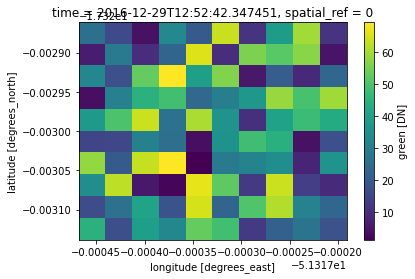

In [7]:
xds_lonlat.green.where(xds_lonlat.green!=xds_lonlat.green.rio.nodata).isel(time=1).plot()

## Reproject to UTM

API Reference:

- [rio.estimate_utm_crs()](../rioxarray.rst#rioxarray.rioxarray.XRasterBase.estimate_utm_crs)

In [8]:
xds_utm = xds.rio.reproject(xds.rio.estimate_utm_crs())
xds_utm.rio.crs

CRS.from_epsg(32722)

## Reproject Large Rasters with Virtual Warping

Using [WarpedVRT](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html) enables re-projection from disk and reduces the amount
of memory required with the re-projection.

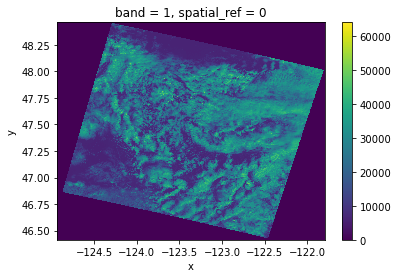

In [9]:
url = (
    "https://storage.googleapis.com/"
    "gcp-public-data-landsat/LC08/01/047/027/"
    "LC08_L1TP_047027_20130421_20170310_01_T1/"
    "LC08_L1TP_047027_20130421_20170310_01_T1_B4.TIF"
)
env = rasterio.Env(
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    CPL_VSIL_CURL_USE_HEAD=False,
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS="TIF",
)
with env:
    with rasterio.open(url) as src:
        with rasterio.vrt.WarpedVRT(src, crs="EPSG:4326") as vrt:
            rds = rioxarray.open_rasterio(vrt)
            rds.sel(band=1).plot.imshow()